In [23]:
import pickle
import scipy.sparse as sparse
import numpy as np
import networkx
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

In [40]:
def plot(_matrix,x,names):
    """
    Hiển thị đồ thị
    """
    _g = networkx.Graph()
    for i in range(len(x)):
        for j in range(len(x)):
            if _matrix[i][j] != 0:
                _g.add_edge("{0} {1:.2f}".format(names[i],x[i]),"{0} {1:.2f}".format(names[j],x[j]),weight=_matrix[i][j])
    plt.figure(figsize=(15,15))
    networkx.draw_networkx(_g)
    
    plt.show()

In [2]:
def read_users(users_path):
    """
    Đọc dữ liệu tên người sử dụng
    """
    with open(users_path, mode='rb') as f:
        users = pickle.load(f)
    return users

def read_map(map_path):
    """
    Bảng tên các đỉnh tương ứng với tên người sử dụng
    """
    with open(map_path, mode='rb') as f:
        index_id_map = pickle.load(f)
    return index_id_map

def read_link_matrix(link_matrix_path, is_sparse=False):
    """
    Đọc đồ thị
    """
    with open(link_matrix_path, mode='rb') as f:
        if is_sparse:
            link_matrix = sparse.load_npz(link_matrix_path)
        else:
            link_matrix = np.load(f)
    return link_matrix

## Thuật toán hit-hub
Input: Ma trận kề A của đồ thị web

Output: Giá trị hub $u$, authority $v$ của các web

$\left\{\begin{matrix}
v=A^t \cdot u\\ 
u = A\cdot v
\end{matrix}\right.$


In [3]:
def hit_hub(__link_matrix,epsilon=1e-4):
#     __link_matrix = link_matrix
    __link_matrix_tr = __link_matrix.transpose()
    __n = __link_matrix.shape[0]
    __hubs = np.ones(__n)
    __auths = np.ones(__n)
    epsilon_matrix = epsilon * np.ones(__n)
    while True:
        hubs_old = __hubs
        auths_old = __auths

        __auths = np.dot(__link_matrix_tr, hubs_old)
        max_score = __auths.max(axis=0)
        if max_score != 0:
            __auths = __auths / max_score
            
        __hubs = np.dot(__link_matrix, __auths)
        max_score = __hubs.max(axis=0)
        if max_score != 0:
            __hubs = __hubs / max_score
            
        if (((abs(__hubs - hubs_old)) < epsilon_matrix).all()) and (
        ((abs(__auths - auths_old)) < epsilon_matrix).all()):
            break
    return __hubs,__auths


## Thuật toán pagerank

In [4]:
def pageRank(G,rsp=0.1, maxerr = .001):
    """
    Tính giá trị pagerank cho trang web
    Args
    ----------
    G: Ma trận kề của đồ thị web
    Kwargs
    ----------
    maxerr: Sai số giữa hai lần cập nhật pagerank
    """
    n = G.shape[0]
    M = csc_matrix(G,dtype=np.float)
    rsums = np.array(M.sum(1))[:,0]
    ri, ci = M.nonzero()
    M.data /= rsums[ri]
    alpha = rsp/n
    M = M.todense()
    M = M*(1-rsp) + alpha

    ro, r = np.zeros(n), np.ones(n)
    while np.sum(np.abs(r-ro)) > maxerr:
        ro = r.copy()
        r = ro.dot(M)
    r = r.tolist()[0]
    return r/np.sum(r)

## Page rank cải tiến
Thuật toán pagerank cải tiến lặp theo công thức
$\textbf{r}= \alpha\textbf{M}^{T}\textbf{r}+\frac{1}{n}\textbf{e}-\Vert\alpha\textbf{M}^{T}\textbf{r}\Vert$

In [28]:
def pageRank_cai_tien(G, s = .85, maxerr = .001):
    """
    Tính giá trị pagerank cho trang web
    Args
    ----------
    G: Ma trận kề của đồ thị web
    Kwargs
    ----------
    s: Hệ số alpha. Mặc định để 0.85
    maxerr: Sai số giữa hai lần cập nhật pagerank
    """
    n = G.shape[0]
    M = csc_matrix(G,dtype=np.float)
    rsums = np.array(M.sum(1))[:,0]
    ri, ci = M.nonzero()
    M.data /= rsums[ri]
    sink = rsums==0
    ro, r = np.zeros(n), np.ones(n)
    
    n_iter = 0
    while np.sum(np.abs(r-ro)) > maxerr:
        ro = r.copy()
        for i in range(0,n):
            Ii = np.array(M[:,i].todense())[:,0]
            Si = sink / float(n)
            Ti = np.ones(n) / float(n)

            r[i] = ro.dot( Ii*s + Si*s + Ti*(1-s) )
        n_iter+=1
        if n_iter>1000:
            break
    return r/sum(r)

# Thử nghiệm các thuật toán

## Đọc dữ liệu

In [26]:
epsilon = 1e-5
users_path = 'data/users'
map_path = 'data/map'
link_matrix_path = 'data/sparse_link_matrix'
# dense_link_matrix_path = 'data/dense_link_matrix'

users = read_users(users_path)
index_id_map = read_map(map_path)
link_matrix = read_link_matrix(link_matrix_path, is_sparse=True)
size = 40
names = [users[index_id_map[i]]['screen_name'] for i in range(size)]

## Chạy thuật toán Hit-hub

----------------------------------------------------------------------------------------------------
|Tên                                     |Chỉ số hub                   |Chỉ số authority             |
----------------------------------------------------------------------------------------------------
|Harish50685414                          |                          1.0|                          0.0|
|vishwaaoo7vi                            |       2.5363564628132478e-05|                          0.0|
|fstopfm                                 |                          0.0|                          0.0|
|Svend38                                 |       1.7429708894049814e-30|                          0.0|
|trgokul97                               |                          0.0|           0.4290096619043105|
|charlottesmckee                         |       2.6680467399173793e-07|                          0.0|
|iamthebaldeagle                         |       2.6680467399173793e-07|     

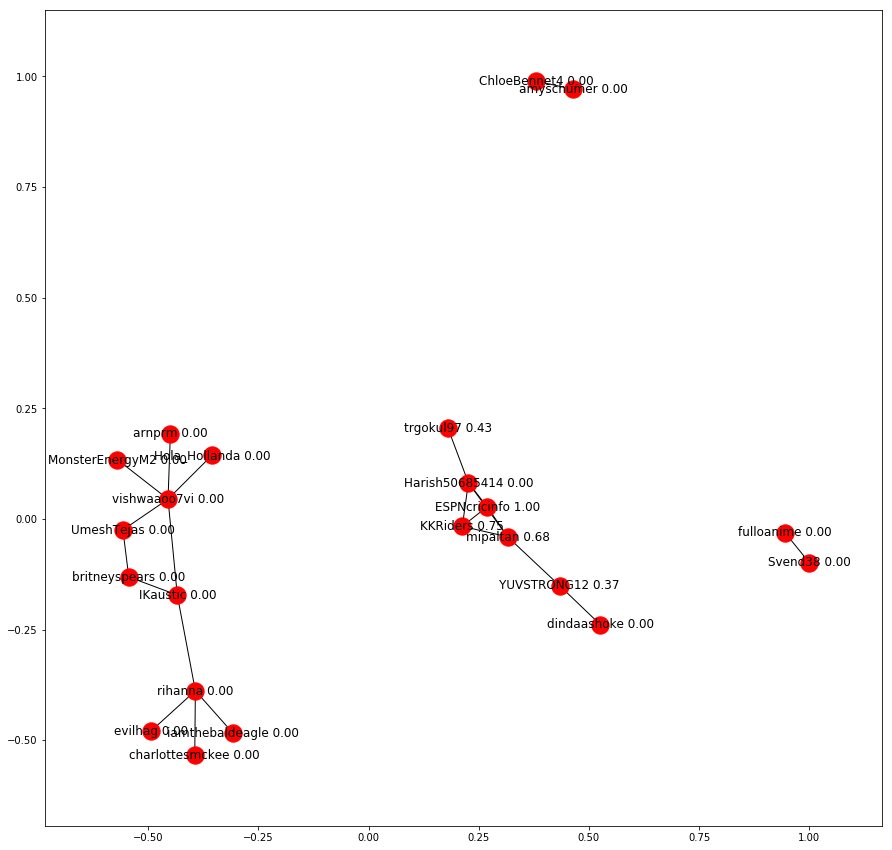

In [41]:
hubs,auths = hit_hub(link_matrix[0:size,0:size].toarray(),epsilon)
# print(auths)
print('-'*100)
print('|{0:40}|{1:29}|{2:29}|'.format('Tên','Chỉ số hub','Chỉ số authority'))
print('-'*100)  
for name,hub,auth in zip(names,hubs,auths):
    print('|{0:40}|{1:29}|{2:29}|'.format(name,hub,auth))
print('-'*100)   

plot(link_matrix[0:size,0:size].toarray(),auths,names)

## Chạy thuật toán pagerank

----------------------------------------------------------------------
|Tên                                     |Chỉ số pagerank              |
----------------------------------------------------------------------
|Harish50685414                          |         0.006594428416018323|
|vishwaaoo7vi                            |         0.006594428416018323|
|fstopfm                                 |         0.006594428416018323|
|Svend38                                 |         0.006594428416018323|
|trgokul97                               |         0.010512722803021433|
|charlottesmckee                         |         0.006594428416018323|
|iamthebaldeagle                         |         0.006594428416018323|
|KKRiders                                |          0.03330103438572502|
|christondcosta                          |         0.006594428416018323|
|fulloanime                              |         0.010512722803021431|
|Hola_Hollanda                           |          0.0

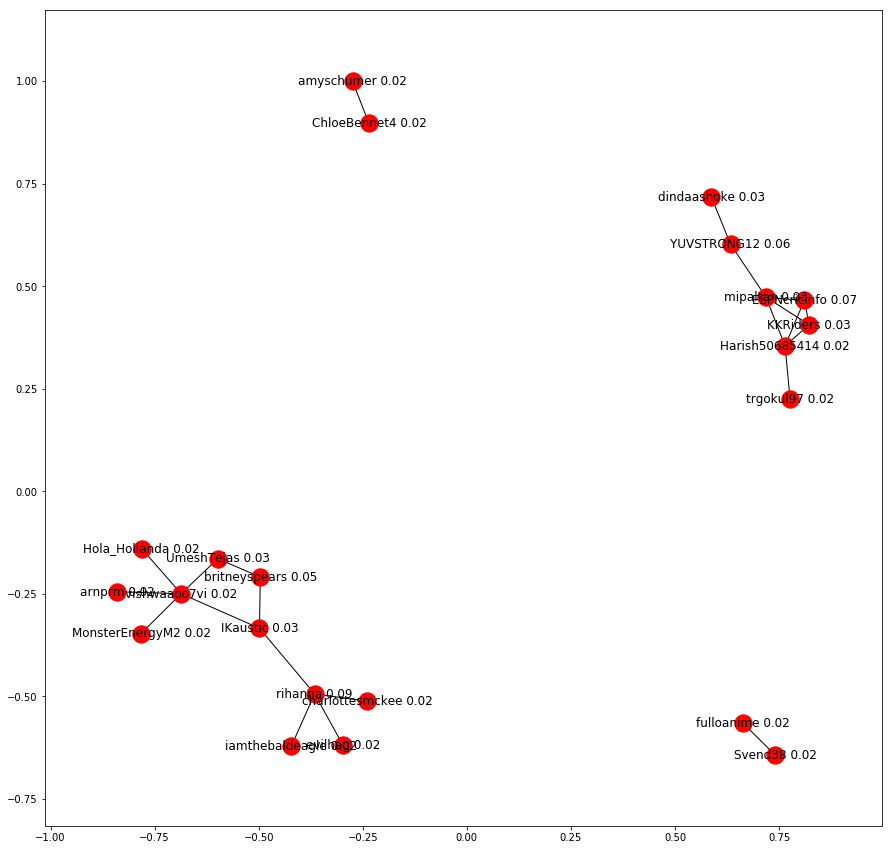

In [42]:
prs = pageRank(link_matrix[0:size,0:size],maxerr = .001)
print('-'*70)
print('|{0:40}|{1:27}|'.format('Tên','Chỉ số pagerank'))
print('-'*70)  
for name,pr in zip(names,prs):
    print('|{0:40}|{1:27}|'.format(name,pr))
print('-'*70)   
plot(link_matrix[0:size,0:size].toarray(),prs,names)

## Chạy thuật toán pagerank cải tiến

----------------------------------------------------------------------
|Tên                                     |Chỉ số pagerank            |
----------------------------------------------------------------------
|Harish50685414                          |        0.01818107338843714|
|vishwaaoo7vi                            |        0.01818107338843714|
|fstopfm                                 |        0.01818107338843714|
|Svend38                                 |        0.01818107338843714|
|trgokul97                               |       0.022103281799545925|
|charlottesmckee                         |        0.01818107338843714|
|iamthebaldeagle                         |        0.01818107338843714|
|KKRiders                                |       0.028950109714889895|
|christondcosta                          |        0.01818107338843714|
|fulloanime                              |        0.02210328179954593|
|Hola_Hollanda                           |        0.02131884011732417|
|dinda

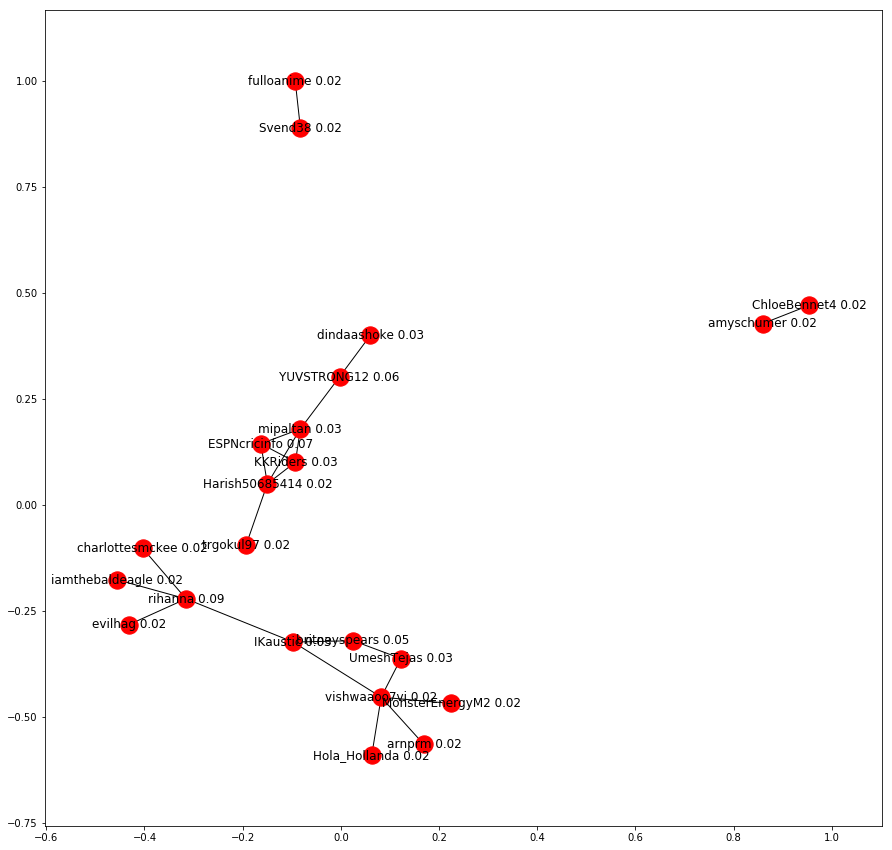

In [44]:
prs = pageRank_cai_tien(link_matrix[0:size,0:size],maxerr = .001)
print('-'*70)
print('|{0:40}|{1:27}|'.format('Tên','Chỉ số pagerank'))
print('-'*70)  
for name,pr in zip(names,prs):
    print('|{0:40}|{1:27}|'.format(name,pr))
print('-'*70)   
plot(link_matrix[0:size,0:size].toarray(),prs,names)